In [1]:
import pandas as pd
import polars as pl
import numpy as np
import glob
import os
import time
import psutil
import gc
import joblib
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import input_file_name, regexp_extract
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
import os
import glob
import time
import psutil
import pandas as pd

def loadCSVToDataFrame(path, prefix: str = "defined_prefix") -> pd.DataFrame:
    """
    Load multiple CSV files with a specific prefix from a fixed folder
    into a single pandas DataFrame, with memory/time tracking, filename column,
    and bus_id column based on filename (B183 -> 183, B208 -> 208).

    Args:
        path (str): Path to folder containing CSV files.
        prefix (str): Prefix of the filenames to match.

    Returns:
        pd.DataFrame: Concatenated DataFrame of all matched CSV files.
    """
    start_time = time.time()
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024 ** 2)  # MB

    # File matching pattern
    file_pattern = os.path.join(path, f"{prefix}*.csv")
    csv_files = glob.glob(file_pattern)

    if not csv_files:
        raise FileNotFoundError(f"No files found matching pattern: {file_pattern}")

    # Load and tag each file with filename and bus_id
    df_list = []
    for file in csv_files:
        temp_df = pd.read_csv(file, engine='pyarrow')
        filename = os.path.splitext(os.path.basename(file))[0]  # Extract filename
        temp_df["source_file"] = filename
        
        # Assign bus_id based on filename
        # Metadata has this information
        #if "B183" in filename:
        #    temp_df["bus_id"] = 183
        #elif "B208" in filename:
        #    temp_df["bus_id"] = 208
        #else:
        #    temp_df["bus_id"] = None  # or np.nan

        df_list.append(temp_df)

    combined_df = pd.concat(df_list, ignore_index=True)

    mem_after = process.memory_info().rss / (1024 ** 2)  # MB
    elapsed_time = time.time() - start_time

    print(f"✅ Loaded {len(csv_files)} files into DataFrame")
    print(f"⏱ Load time: {elapsed_time:.2f} seconds")
    print(f"💾 Memory before: {mem_before:.2f} MB")
    print(f"💾 Memory after:  {mem_after:.2f} MB")
    print(f"📊 DataFrame shape: {combined_df.shape}")

    return combined_df

In [3]:
#Due to a smaller data size, this function is not in use as Spark takes longer for data load operations

def readCombineCSVSafe(folder_path, prefix, max_memory_fraction=0.1):
    """
    Reads CSVs into a Spark or pandas DataFrame, measures load time,
    estimates memory usage, and adds a 'source_file' column with the file name.

    Parameters:
        folder_path (str): Path to folder containing CSV files.
        prefix (str): Prefix of files to match (e.g., "ACY").
        max_memory_fraction (float): Max fraction of available RAM for pandas conversion.

    Returns:
        tuple: (DataFrame, load_time_seconds)
    """
    spark = SparkSession.builder \
        .appName("Timed CSV Loader with Memory Check + Filename") \
        .master("local[*]") \
        .getOrCreate()

    file_pattern = f"{folder_path}/{prefix}*.csv"

    start_time = time.time()

    # Read CSVs and add source file path column
    df_spark = spark.read.csv(file_pattern, header=True, inferSchema=True) \
        .withColumn("source_file_path", input_file_name())

    # Extract only the file name from the path
    df_spark = df_spark.withColumn(
        "source_file",
        regexp_extract("source_file_path", r"([^/\\]+$)", 1)
    )

    total_rows = df_spark.count()
    total_columns = len(df_spark.columns)

    # Estimate dataset memory size
    sample_pdf = df_spark.limit(1000).toPandas()
    sample_size_bytes = sample_pdf.memory_usage(deep=True).sum()
    estimated_size_bytes = (sample_size_bytes / len(sample_pdf)) * total_rows

    available_mem_bytes = psutil.virtual_memory().available
    safe_limit_bytes = available_mem_bytes * max_memory_fraction

    load_time = time.time() - start_time

    print(f"⏱ Load time: {load_time:.2f} seconds")
    print(f"📊 Estimated dataset size: {estimated_size_bytes / (1024**2):.2f} MB")
    print(f"💾 Available memory limit: {safe_limit_bytes / (1024**2):.2f} MB")

    if estimated_size_bytes <= safe_limit_bytes:
        print(f"✅ Converting to pandas DataFrame ({total_rows} rows, {total_columns} columns)")
        return df_spark.toPandas(), load_time
    else:
        print(f"⚠ Too large for pandas. Returning Spark DataFrame.")
        return df_spark, load_time


In [4]:
def ram_usage():
    """
    Returns current RAM usage (used/total) in MB and percentage.
    """
    mem = psutil.virtual_memory()
    used_mb = mem.used / (1024 ** 2)
    total_mb = mem.total / (1024 ** 2)
    percent = mem.percent
    
    print(f"RAM Used: {used_mb:.2f} MB / {total_mb:.2f} MB ({percent}%)")
    #return mem.percent  # Returning percentage for programmatic use

In [5]:
#Functions created to separately analyze the different bus datasets
#This will be used at a later stage to analyze individual buses

def checkDataFrameStructure(df1, df2):
    """
        Check if DataFrames have same column names in same order.
        Simply return a boolean value if the column names match.
    """
    return list(df1.columns) == list(df2.columns)

def mergeDataFrames(df1, df2):
    """
        If same structure, concatenate and delete originals.
        Ensure to also delete the original dataframes 
    """
    if checkDataFrameStructure(df1, df2):
        merged_df = pd.concat([df1, df2], ignore_index=True)
        del df1
        del df2
        print("DataFrames had same structure — merged successfully.")
        return merged_df
    else:
        print("DataFrames do not have the same structure.")
        return None

In [6]:
def missingPercentage(df, extra_missing_values=None):
    """
    Calculates missing value percentage for each column.
    
    Parameters:
    - df: pandas DataFrame
    - extra_missing_values: list of values to treat as missing 
      (e.g., ['-', 'NA', 'N/A', ''])
    
    Returns:
    DataFrame with columns:
    - 'missing_count'
    - 'missing_percent'
    """
    df_copy = df.copy()

    # Replace extra placeholders with NaN
    if extra_missing_values is not None:
        df_copy.replace(extra_missing_values, np.nan, inplace=True)

    total_rows = len(df_copy)
    missing_count = df_copy.isnull().sum()
    missing_percent = (missing_count / total_rows) * 100

    result = pd.DataFrame({
        'missing_count': missing_count,
        'missing_percent': missing_percent
    }).sort_values(by='missing_percent', ascending=False)

    return result

In [7]:
def reduceMemoryUsage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Initial size: {start_mem:.2f} MB")
    
    # Store column info
    col_info = []

    for col in df.columns:
        col_type = df[col].dtype
        c_min, c_max = None, None  # default if not numeric

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min, c_max = df[col].min(), df[col].max()
            
            if str(col_type).startswith("int"):
                if c_min >= 0:
                    if c_max < 255:
                        df[col] = df[col].astype("uint8")
                    elif c_max < 65535:
                        df[col] = df[col].astype("uint16")
                    elif c_max < 4294967295:
                        df[col] = df[col].astype("uint32")
                    else:
                        df[col] = df[col].astype("uint64")
                else:
                    if np.iinfo("int8").min <= c_min <= np.iinfo("int8").max:
                        df[col] = df[col].astype("int8")
                    elif np.iinfo("int16").min <= c_min <= np.iinfo("int16").max:
                        df[col] = df[col].astype("int16")
                    elif np.iinfo("int32").min <= c_min <= np.iinfo("int32").max:
                        df[col] = df[col].astype("int32")
                    else:
                        df[col] = df[col].astype("int64")
                        
            elif str(col_type).startswith("float"):
                df[col] = pd.to_numeric(df[col], downcast="float")
                c_min, c_max = df[col].min(), df[col].max()  # recalc after downcast
                
        else:
            df[col] = df[col].astype("category")
        
        # Append column info
        col_info.append({
            "column": col,
            "dtype": df[col].dtype,
            "min": c_min,
            "max": c_max
        })
            
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Reduced size: {end_mem:.2f} MB ({100 * (start_mem - end_mem)/start_mem:.1f}% reduction)")

    # Convert collected info into DataFrame
    col_summary = pd.DataFrame(col_info)

    return df, col_summary


In [8]:
def getNonNumericCols(df):
    """
    Returns a list of column names in the DataFrame
    that are not numeric (includes object, category, bool, datetime, etc.).
    """
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    return non_numeric_cols

In [9]:
def removeOutliersIQR(df, column):
    """
    Detects outliers in a DataFrame column using the IQR method 
    and replaces them with NaN (to allow interpolation later).
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        column (str): Column name to process
    
    Returns:
        pd.DataFrame: DataFrame with outliers replaced by NaN
    """
    # Calculate Q1 and Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN
    df[column] = df[column].where(
        (df[column] >= lower_bound) & (df[column] <= upper_bound),
        np.nan
    )
    
    return df

In [10]:
def handleMissingSensorData(df, col, method='auto'):
    if method == 'auto':
        # Forward-fill short gaps, interpolate medium gaps
        df[col] = df[col].ffill(limit=5)  # up to 5 consecutive missing
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
    elif method == 'ffill':
        df[col] = df[col].ffill().bfill()
    elif method == 'interpolate':
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
    return df

In [11]:
def reduceDrivingFeatures(df: pd.DataFrame, corr_threshold: float = 0.9) -> pd.DataFrame:
    """
    Reduce odometry/traction/status features by combining redundant ones and
    removing highly correlated columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with all features.
    corr_threshold : float, default=0.9
        Threshold for removing correlated features.
    
    Returns
    -------
    pd.DataFrame
        Reduced dataframe with fewer, more informative features.
    """
    
    # --- Domain-driven reduction ---
    # Combine wheel speeds into mean and differences
    df = df.copy()
    
    # --- Domain-driven reduction ---
    wheel_cols = [
        'odometry_wheelSpeed_fl', 'odometry_wheelSpeed_fr',
        'odometry_wheelSpeed_ml', 'odometry_wheelSpeed_mr',
        'odometry_wheelSpeed_rl', 'odometry_wheelSpeed_rr'
    ]
    
    # Fill NaNs in wheel speeds with 0 (or you can choose another strategy)
    df[wheel_cols] = df[wheel_cols].fillna(0)
    
    # Mean wheel speed
    df['wheelSpeed_mean'] = df[wheel_cols].mean(axis=1)
    
    # Left-right difference
    df['wheelSpeed_left_right_diff'] = (
        (df['odometry_wheelSpeed_fl'] + df['odometry_wheelSpeed_ml'] + df['odometry_wheelSpeed_rl']) / 3
        - (df['odometry_wheelSpeed_fr'] + df['odometry_wheelSpeed_mr'] + df['odometry_wheelSpeed_rr']) / 3
    )
    
    # Combine brake flags into a single categorical feature
    df['brake_status'] = (
        pd.to_numeric(df['status_haltBrakeIsActive'], errors='coerce').fillna(0).astype(int) +
        2 * pd.to_numeric(df['status_parkBrakeIsActive'], errors='coerce').fillna(0).astype(int)
        )
    # 0 = no brake, 1 = halt brake, 2 = park brake, 3 = both
    
    # Drop raw features already aggregated
    drop_cols = [
        'odometry_wheelSpeed_fl', 'odometry_wheelSpeed_fr',
        'odometry_wheelSpeed_ml', 'odometry_wheelSpeed_mr',
        'odometry_wheelSpeed_rl', 'odometry_wheelSpeed_rr',
        'status_haltBrakeIsActive', 'status_parkBrakeIsActive'
    ]
    df_reduced = df.drop(columns=drop_cols, errors="ignore")

    #These features are generalized versions of the metadata. We do not need them for prediction purposes.
    drop_generalized = ['drivenDistance', 'energyConsumption']
    
    df_reduced = df_reduced.drop(columns=drop_generalized, errors="ignore")
    
    # --- Statistical reduction ---
    # Remove highly correlated features
    #corr = df_reduced.corr().abs()
    #upper = corr.where(~pd.np.tril(pd.np.ones(corr.shape)).astype(bool))  # upper triangle
    #to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    
    #df_final = df_reduced.drop(columns=to_drop, errors="ignore")
    
    return df_reduced


In [12]:
def plotNumericCorrelations(df: pd.DataFrame, corr_threshold: float = 0.9):
    """
    Plot correlation heatmap for numerical features and list highly correlated pairs.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with features.
    corr_threshold : float, default=0.9
        Threshold above which features are considered correlated.

    Returns
    -------
    correlated_pairs : list of tuples
        List of correlated feature pairs with correlation above threshold.
    """
    # Select only numeric columns (all int/float types)
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Compute correlation matrix
    corr = numeric_df.corr()

    # --- Plot heatmap ---
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Correlation coefficient")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Numerical Feature Correlation Heatmap", fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Extract correlated features ---
    correlated_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) > corr_threshold:
                correlated_pairs.append((
                    corr.columns[i],
                    corr.columns[j],
                    corr.iloc[i, j]
                ))
    
    return correlated_pairs

In [13]:
def condenseMinMaxMean(df: pd.DataFrame, min_col: str, mean_col: str, max_col: str,
                          method: str = "weighted", weights: tuple = (0.2, 0.6, 0.2), 
                          lambda_: float = 0.1, new_col: str = "condensed_feature"):
    """
    Condense min, mean, max into one variable using different strategies.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    min_col, mean_col, max_col : str
        Column names for min, mean, and max.
    method : str, default "weighted"
        Method to condense features:
        - "weighted" → weighted average of (min, mean, max).
        - "range_mean" → mean + lambda * (max - min).
        - "pca" → first principal component of [min, mean, max].
    weights : tuple of length 3, default (0.2, 0.6, 0.2)
        Weights for (min, mean, max) when method="weighted".
    lambda_ : float, default 0.1
        Weight for variability (max - min) when method="range_mean".
    new_col : str, default "condensed_feature"
        Name of the new column.
    
    Returns
    -------
    - If method in {"weighted", "range_mean"}:
        pd.DataFrame
    - If method == "pca":
        (pd.DataFrame, PCA object)
    """
    
    df_copy = df.copy()
    
    if method == "weighted":
        a, b, c = weights
        df_copy[new_col] = a * df_copy[min_col] + b * df_copy[mean_col] + c * df_copy[max_col]
        return df_copy
    
    elif method == "range_mean":
        df_copy[new_col] = df_copy[mean_col] + lambda_ * (df_copy[max_col] - df_copy[min_col])
        return df_copy
    
    elif method == "pca":
        X = df_copy[[min_col, mean_col, max_col]].values
        pca = PCA(n_components=1)
        df_copy[new_col] = pca.fit_transform(X)
        return df_copy, pca
    
    else:
        raise ValueError("method must be 'weighted', 'range_mean', or 'pca'")

In [14]:
def condensePassengerFeatures(df, feature_prefix, drop_original=True, add_spread=True):
    """
    Condense min, mean, max passenger features into interpretable condensed features.
    Keeps central tendency (mean), variability (range), and optional normalized spread.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns with suffixes '_min', '_mean', '_max'
    feature_prefix : str
        The prefix of the feature (e.g. 'passengers', 'speed')
    drop_original : bool, default=True
        If True, drop the original min/mean/max columns
    add_spread : bool, default=True
        If True, add normalized spread = (max - min) / mean

    Returns
    -------
    pd.DataFrame
        Updated dataframe with new condensed features
    """
    min_col = f"{feature_prefix}_min"
    mean_col = f"{feature_prefix}_mean"
    max_col = f"{feature_prefix}_max"

    # Safety check
    if not all(col in df.columns for col in [min_col, mean_col, max_col]):
        raise ValueError(f"One or more required columns ({min_col}, {mean_col}, {max_col}) are missing")

    # Create condensed features
    df[f"{feature_prefix}_central"] = df[mean_col]
    df[f"{feature_prefix}_range"] = df[max_col] - df[min_col]

    if add_spread:
        df[f"{feature_prefix}_spread"] = (
            (df[max_col] - df[min_col]) / df[mean_col].replace(0, np.nan)
        )

    # Drop originals if requested
    if drop_original:
        df = df.drop(columns=[min_col, mean_col, max_col])

    return df

In [15]:
def condenseFeaturesHighVariance(df, feature_set, new_feature_name, drop_original=True, threshold=0.99):
    """
    Condense min, mean, max (or similar correlated features) into a single feature.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        feature_set (list): List of correlated features [min, mean, max]
        new_feature_name (str): Name for the condensed feature
        drop_original (bool): Whether to drop original features
        threshold (float): Variance threshold for shortcut (default=0.99)
    
    Returns:
        pd.DataFrame: DataFrame with new condensed feature
    """
    # Select features
    X = df[feature_set].dropna()
    
    # Fit PCA
    pca = PCA(n_components=1)
    pca.fit(X)
    
    explained_var = pca.explained_variance_ratio_[0]
    
    if explained_var >= threshold:
        # ✅ Strong collinearity → just take the mean
        df[new_feature_name] = df[feature_set].mean(axis=1)
        print(f"Using MEAN instead of PCA (explained variance = {explained_var:.4f})")
    else:
        # ⚙️ Use PCA transformation
        df[new_feature_name] = pca.transform(df[feature_set])[:, 0]
        print(f"Using PCA (explained variance = {explained_var:.4f})")
        print(f"PCA components: {pca.components_}")
    
    # Drop original features if requested
    if drop_original:
        df = df.drop(columns=feature_set)
    
    return df

In [16]:
def engineergnssFeatures(df, course_col="gnss_course", speed_col="odometry_vehicleSpeed", stationary_threshold=0.1, window=50):
    """
    Engineer GNSS course features for classification between Bus 183 and Bus 208.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing gnss_course and vehicle speed.
    course_col : str
        Column name for GNSS course in radians.
    speed_col : str
        Column name for vehicle speed.
    stationary_threshold : float
        Speed threshold below which the bus is considered stationary.
    window : int
        Rolling window size for variance/mean calculation when stationary.
    
    Returns
    -------
    df : pd.DataFrame
        DataFrame with new engineered features.
    """

    # Detect stationary
    df["is_stationary"] = (df[speed_col] < stationary_threshold).astype(int)

    # Flag: GNSS course is zero when stationary (Bus 208 behavior)
    df["gnss_course_stationary_zero_flag"] = ((df["is_stationary"] == 1) & (df[course_col] == 0)).astype(int)

    # Rolling statistics when stationary (Bus 183 → constant nonzero, Bus 208 → always zero)
    df["gnss_course_stationary_mean"] = (
        df[course_col].where(df["is_stationary"] == 1).rolling(window, min_periods=1).mean()
    )
    df["gnss_course_stationary_var"] = (
        df[course_col].where(df["is_stationary"] == 1).rolling(window, min_periods=1).var()
    ).fillna(0)

    # Angular encoding (works well during movement too)
    df["gnss_course_sin"] = np.sin(df[course_col])
    df["gnss_course_cos"] = np.cos(df[course_col])

    # Drop raw gnss_course if you don’t want circularity issues
    df = df.drop(columns=[course_col])

    return df

In [17]:
def getDataFrameDTypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return the datatype of each column in the DataFrame.

    Args:
        df (pd.DataFrame): Input pandas DataFrame.

    Returns:
        pd.DataFrame: DataFrame with columns and their datatypes.
    """
    dtype_df = pd.DataFrame(df.dtypes, columns=["dtype"]).reset_index()
    dtype_df.columns = ["column", "dtype"]
    return dtype_df

In [18]:
os.getcwd()

'E:\\datapao'

In [19]:
data_path = "E:/datapao/ZTBus/"

In [20]:
metadata = pd.read_csv('metaData.csv')
metadata = metadata.drop(columns = ['startTime_iso', 'startTime_unix', 'endTime_iso', 'endTime_unix'])

-- Markdown Section

In [21]:
#B183_pandasDF = loadCSVToDataFrame(data_path, "B183*")
#B208_pandasDF = loadCSVToDataFrame(data_path, "B208*")
#B208_pandasDF.head()
#B183_pandasDF = B183_pandasDF.merge(metadata2, left_on = 'source_file', right_on = 'name', how = 'left')
#B208_pandasDF = B208_pandasDF.merge(metadata2, left_on = 'source_file', right_on = 'name', how = 'left')

In [22]:
ram_usage()

RAM Used: 10287.15 MB / 32471.92 MB (31.7%)


In [23]:
ZTBus = loadCSVToDataFrame(data_path, "B*")

✅ Loaded 1409 files into DataFrame
⏱ Load time: 135.44 seconds
💾 Memory before: 241.48 MB
💾 Memory after:  20655.43 MB
📊 DataFrame shape: (48674462, 27)


In [24]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 10026.63 MB
Reduced size: 5431.14 MB (45.8% reduction)


In [25]:
ZTBus = ZTBus.merge(metadata, left_on = 'source_file', right_on = 'name', how = 'left')

In [26]:
del metadata

In [27]:
gc.collect()

0

In [28]:
ram_usage()

RAM Used: 17625.41 MB / 32471.92 MB (54.3%)


In [29]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 10165.89 MB
Reduced size: 7380.80 MB (27.4% reduction)


In [30]:
ZTBus_Summary

,column,dtype,min,max
0,time_iso,"datetime64[s, UTC]",2019-04-30 03:18:56+00:00,2022-12-11 03:29:05+00:00
1,time_unix,uint32,1556594336,1670729345
2,electric_powerDemand,float64,-322797.0,381340.3
3,gnss_altitude,float32,-1011.752014,4657.081055
4,gnss_course,float32,0.0,6.283185
5,gnss_latitude,float32,0.822585,0.853783
6,gnss_longitude,float32,-0.051144,0.159485
7,itcs_busRoute,category,None,None
8,itcs_numberOfPassengers,float32,0.0,131.0
9,itcs_stopName,category,None,None


In [31]:
ZTBus.describe()

,time_unix,electric_powerDemand,gnss_altitude,gnss_course,gnss_latitude,gnss_longitude,itcs_numberOfPassengers,odometry_articulationAngle,odometry_steeringAngle,odometry_vehicleSpeed,...,busNumber,drivenDistance,energyConsumption,itcs_numberOfPassengers_mean,itcs_numberOfPassengers_min,itcs_numberOfPassengers_max,status_gridIsAvailable_mean,temperature_ambient_mean,temperature_ambient_min,temperature_ambient_max
count,4.867446e+07,4.867446e+07,4.734358e+07,4.734528e+07,4.734529e+07,4.734529e+07,444738.000000,4.867446e+07,4.867446e+07,4.867446e+07,...,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07,4.867446e+07
mean,1.627992e+09,2.478952e+04,4.400245e+02,2.602361e+00,8.270245e-01,1.487024e-01,17.887466,1.752685e-02,2.267342e-02,4.263831e+00,...,1.921352e+02,1.985147e+05,1.154825e+09,1.784426e+01,2.312103e-01,6.585355e+01,6.590821e-01,2.893997e+02,2.852818e+02,2.956784e+02
std,3.330665e+07,6.784718e+04,3.257275e+01,2.011340e+00,2.476776e-04,3.746242e-04,13.821078,8.845592e-02,1.155644e-01,4.207733e+00,...,1.203861e+01,8.190737e+04,4.995213e+08,5.430501e+00,6.629398e-01,2.175455e+01,2.109425e-01,7.288150e+00,6.228632e+00,5.626224e+00
min,1.556594e+09,-3.227970e+05,-1.011752e+03,0.000000e+00,8.225854e-01,-5.114448e-02,0.000000,-9.424800e-01,-9.424800e-01,-8.477243e-01,...,1.830000e+02,3.886427e+04,1.947412e+08,1.685185e+00,0.000000e+00,8.000000e+00,2.165135e-01,2.741103e+02,2.731500e+02,2.791500e+02
25%,1.604595e+09,3.186402e+03,4.151000e+02,5.776362e-01,8.268975e-01,1.483610e-01,8.000000,8.726646e-03,0.000000e+00,0.000000e+00,...,1.830000e+02,1.475090e+05,8.370118e+08,1.435750e+01,0.000000e+00,5.000000e+01,4.698786e-01,2.830275e+02,2.801500e+02,2.911500e+02
50%,1.635432e+09,9.666712e+03,4.257716e+02,2.401412e+00,8.270337e-01,1.487095e-01,15.000000,1.745333e-02,8.726667e-03,3.557555e+00,...,1.830000e+02,2.098937e+05,1.213240e+09,1.794090e+01,0.000000e+00,6.400000e+01,5.329543e-01,2.895523e+02,2.854970e+02,2.941500e+02
75%,1.656400e+09,4.378899e+04,4.714848e+02,4.413938e+00,8.272278e-01,1.489492e-01,24.000000,4.363333e-02,3.490667e-02,7.874786e+00,...,2.080000e+02,2.489304e+05,1.506657e+09,2.120461e+01,0.000000e+00,8.100000e+01,8.815500e-01,2.950798e+02,2.911500e+02,2.991500e+02
max,1.670729e+09,3.813403e+05,4.657081e+03,6.283185e+00,8.537830e-01,1.594845e-01,131.000000,9.337533e-01,9.424800e-01,1.920769e+01,...,2.080000e+02,3.867413e+05,2.684731e+09,3.980899e+01,1.700000e+01,1.310000e+02,1.000000e+00,3.075008e+02,3.031500e+02,3.111500e+02


In [32]:
#ZTBus.head()

In [33]:
print(getNonNumericCols(ZTBus))

['time_iso', 'itcs_busRoute', 'itcs_stopName', 'source_file', 'name', 'busRoute']


In [34]:
print(missingPercentage(ZTBus))

                              missing_count  missing_percent
itcs_numberOfPassengers            48229724        99.086301
gnss_altitude                       1330884         2.734255
gnss_course                         1329182         2.730758
gnss_longitude                      1329169         2.730732
gnss_latitude                       1329169         2.730732
status_gridIsAvailable                  109         0.000224
status_haltBrakeIsActive                109         0.000224
status_doorIsOpen                       109         0.000224
status_parkBrakeIsActive                109         0.000224
temperature_ambient                     103         0.000212
electric_powerDemand                      0         0.000000
time_unix                                 0         0.000000
time_iso                                  0         0.000000
itcs_stopName                             0         0.000000
itcs_busRoute                             0         0.000000
odometry_wheelSpeed_fr  

In [35]:
ZTBus.drop(columns = ['itcs_numberOfPassengers', 'time_iso', 'itcs_stopName', 'source_file', 'name'], inplace = True)

In [36]:
ZTBus = ZTBus[ZTBus['busRoute'] != '-']

In [37]:
ZTBus['busRoute'] = ZTBus['busRoute'].cat.remove_unused_categories()

In [38]:
ZTBus.busRoute.unique()

['31', '33', '72', '46', '32', '83', 'N4', 'N2', 'N1']
Categories (9, object): ['31', '32', '33', '46', ..., '83', 'N1', 'N2', 'N4']

In [39]:
print(missingPercentage(ZTBus))

                              missing_count  missing_percent
gnss_altitude                       1297284         2.695420
gnss_course                         1295582         2.691884
gnss_latitude                       1295569         2.691857
gnss_longitude                      1295569         2.691857
status_gridIsAvailable                  109         0.000226
status_doorIsOpen                       109         0.000226
status_parkBrakeIsActive                109         0.000226
status_haltBrakeIsActive                109         0.000226
temperature_ambient                     103         0.000214
time_unix                                 0         0.000000
electric_powerDemand                      0         0.000000
odometry_vehicleSpeed                     0         0.000000
odometry_wheelSpeed_fl                    0         0.000000
odometry_wheelSpeed_fr                    0         0.000000
odometry_wheelSpeed_mr                    0         0.000000
odometry_steeringAngle  

In [40]:
gc.collect()

0

In [41]:
ram_usage()

RAM Used: 13955.76 MB / 32471.92 MB (43.0%)


In [42]:
# Memory in GB
mem_gb = ZTBus.memory_usage(deep=True).sum() / (1024 ** 3)
print(f"DataFrame uses {mem_gb:.2f} GB")

DataFrame uses 6.68 GB


--- This sections starts the treatment of missing values in the dataframe ---

-- Start Visualization of Missing GNSS Sensor --

-- From the missing percentage analysis, we see the sensor data has an approximately 2.7% is missing in all 4. So we use interpolation methods to resolve it. -- 

C:\Users\Saransh\AppData\Local\Temp\ipykernel_6020\20084677.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Temp\ipykernel_6020\20084677.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


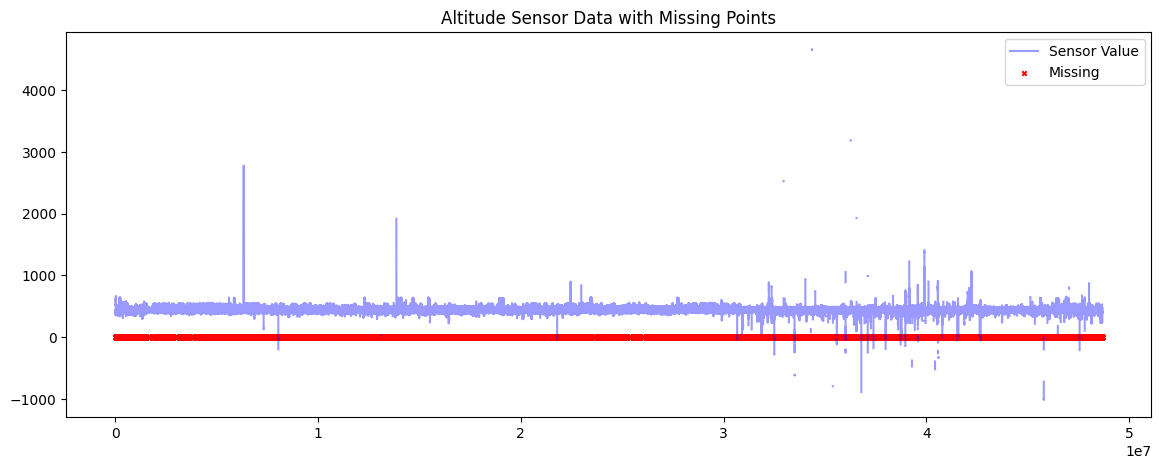

In [43]:
plt.figure(figsize=(14, 5))
plt.plot(ZTBus.index, ZTBus['gnss_altitude'], color='blue', alpha=0.4, label='Sensor Value')

# Plot missing points
plt.scatter(ZTBus.index[ZTBus['gnss_altitude'].isna()], 
            [0]*ZTBus['gnss_altitude'].isna().sum(), 
            color='red', marker='x', label='Missing', s=10)

plt.title('Altitude Sensor Data with Missing Points')
plt.legend()

# Save as JPG
plt.savefig("altitude_sensor_plot.jpg", dpi=300, bbox_inches="tight") 

plt.show()

In [44]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_altitude')

In [45]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_course')

In [46]:
print(missingPercentage(ZTBus))

                              missing_count  missing_percent
gnss_latitude                       1295569         2.691857
gnss_longitude                      1295569         2.691857
status_parkBrakeIsActive                109         0.000226
status_haltBrakeIsActive                109         0.000226
status_gridIsAvailable                  109         0.000226
status_doorIsOpen                       109         0.000226
temperature_ambient                     103         0.000214
time_unix                                 0         0.000000
electric_powerDemand                      0         0.000000
itcs_busRoute                             0         0.000000
odometry_vehicleSpeed                     0         0.000000
odometry_steeringAngle                    0         0.000000
odometry_wheelSpeed_fl                    0         0.000000
odometry_wheelSpeed_fr                    0         0.000000
odometry_wheelSpeed_mr                    0         0.000000
odometry_articulationAng

In [47]:
ZTBus['timestamp'] = pd.to_datetime(ZTBus['time_unix'], unit='s')

In [48]:
ZTBus.drop(columns = ['time_unix'], inplace = True)

In [49]:
ZTBus = removeOutliersIQR(ZTBus, 'gnss_altitude')

C:\Users\Saransh\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


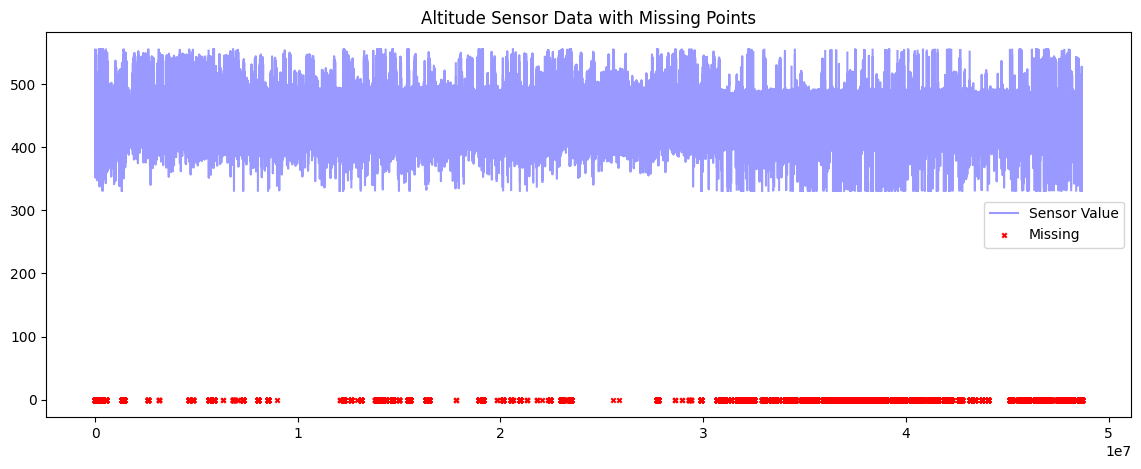

In [50]:
plt.figure(figsize=(14, 5))
plt.plot(ZTBus.index, ZTBus['gnss_altitude'], color='blue', alpha=0.4, label='Sensor Value')

# Plot missing points
plt.scatter(ZTBus.index[ZTBus['gnss_altitude'].isna()], 
            [0]*ZTBus['gnss_altitude'].isna().sum(), 
            color='red', marker='x', label='Missing', s=10)

plt.title('Altitude Sensor Data with Missing Points')
plt.legend()
plt.show()

In [51]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_altitude')

C:\Users\Saransh\AppData\Local\Temp\ipykernel_6020\3494837249.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_clean_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Temp\ipykernel_6020\3494837249.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("altitude_sensor_clean_plot.jpg", dpi=300, bbox_inches="tight")
C:\Users\Saransh\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


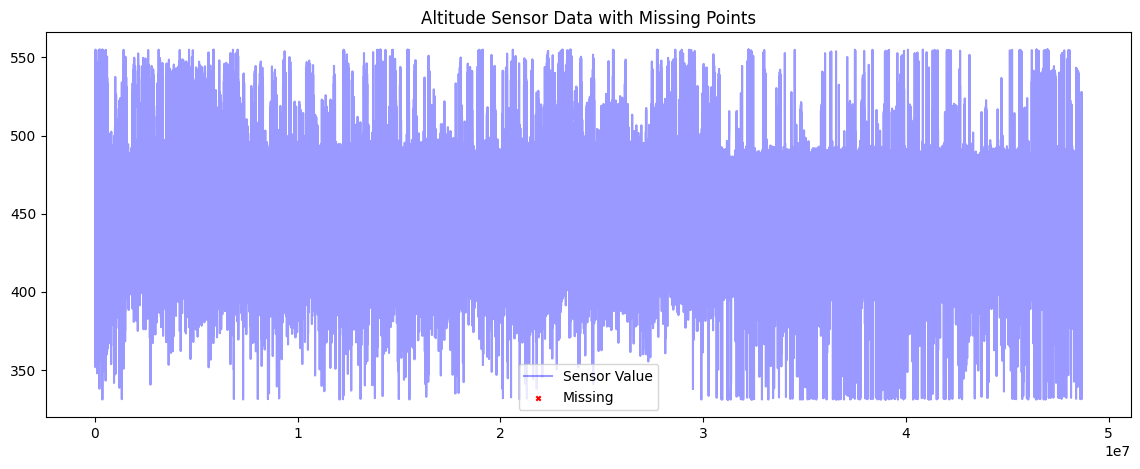

In [52]:
plt.figure(figsize=(14, 5))
plt.plot(ZTBus.index, ZTBus['gnss_altitude'], color='blue', alpha=0.4, label='Sensor Value')

# Plot missing points
plt.scatter(ZTBus.index[ZTBus['gnss_altitude'].isna()], 
            [0]*ZTBus['gnss_altitude'].isna().sum(), 
            color='red', marker='x', label='Missing', s=10)

plt.title('Altitude Sensor Data with Missing Points')
plt.legend()

# Save as JPG
plt.savefig("altitude_sensor_clean_plot.jpg", dpi=300, bbox_inches="tight")

plt.show()

In [53]:
ZTBus = ZTBus.sort_values("timestamp")

#ZTBus['gnss_latitude'] = ZTBus.groupby('timestamp')['gnss_latitude'].transform(lambda x: x.interpolate())
#ZTBus['gnss_longitude'] = ZTBus.groupby('timestamp')['gnss_longitude'].transform(lambda x: x.interpolate())

In [54]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_latitude')

In [55]:
ZTBus = handleMissingSensorData(ZTBus, 'gnss_longitude')

In [56]:
coords = ZTBus[['gnss_latitude', 'gnss_longitude']]
kmeans = KMeans(n_clusters=20, random_state=42)
ZTBus['location_cluster'] = kmeans.fit_predict(coords)

In [57]:
#ZTBus.drop(columns= ['gnss_latitude', 'gnss_longitude'], inplace = True)

In [58]:
ZTBus.location_cluster.unique()

array([13, 18,  0,  9,  6, 11,  4,  5,  7,  8, 12,  3, 14, 15, 19,  2, 16,
       17,  1, 10], dtype=int32)

In [59]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 7206.23 MB
Reduced size: 7068.54 MB (1.9% reduction)


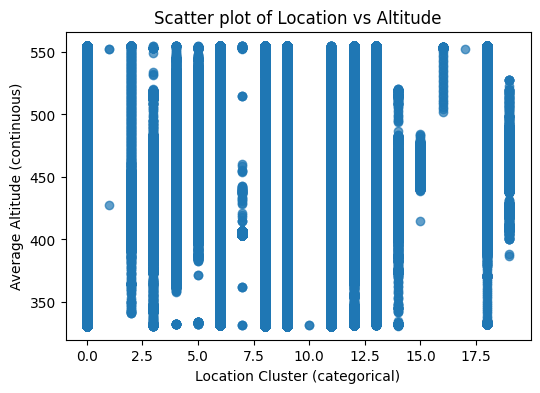

In [60]:
# Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(ZTBus["location_cluster"], ZTBus["gnss_altitude"], alpha=0.7)

plt.xlabel("Location Cluster (categorical)")
plt.ylabel("Average Altitude (continuous)")
plt.title("Scatter plot of Location vs Altitude")
plt.show()

In [61]:
#ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

In [62]:
gc.collect()

13169

In [63]:
ZTBus = reduceDrivingFeatures(ZTBus)

In [64]:
gc.collect()

0

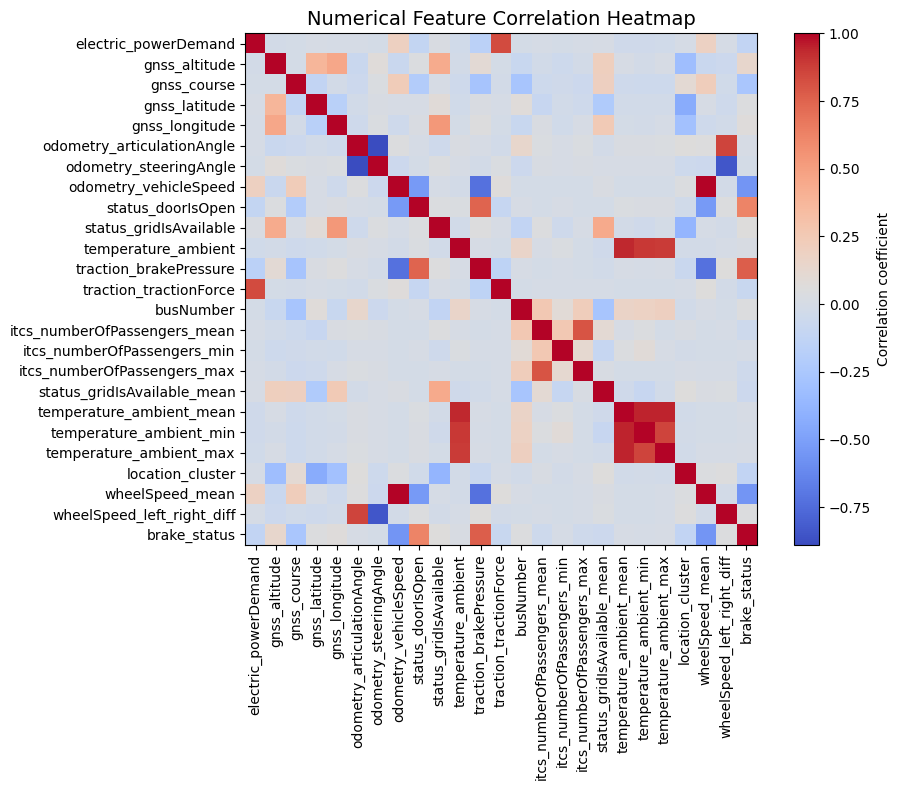

In [65]:
correlated = plotNumericCorrelations(ZTBus, corr_threshold=0.6)

In [66]:
gc.collect()

9018

In [67]:
print("Highly correlated feature pairs:")
for f1, f2, val in correlated:
    print(f"{f1} ↔ {f2} : corr = {val:.2f}")

Highly correlated feature pairs:
electric_powerDemand ↔ traction_tractionForce : corr = 0.83
odometry_articulationAngle ↔ odometry_steeringAngle : corr = -0.89
odometry_articulationAngle ↔ wheelSpeed_left_right_diff : corr = 0.85
odometry_steeringAngle ↔ wheelSpeed_left_right_diff : corr = -0.84
odometry_vehicleSpeed ↔ traction_brakePressure : corr = -0.73
odometry_vehicleSpeed ↔ wheelSpeed_mean : corr = 1.00
status_doorIsOpen ↔ traction_brakePressure : corr = 0.74
status_doorIsOpen ↔ brake_status : corr = 0.62
temperature_ambient ↔ temperature_ambient_mean : corr = 0.94
temperature_ambient ↔ temperature_ambient_min : corr = 0.89
temperature_ambient ↔ temperature_ambient_max : corr = 0.89
traction_brakePressure ↔ wheelSpeed_mean : corr = -0.72
traction_brakePressure ↔ brake_status : corr = 0.76
itcs_numberOfPassengers_mean ↔ itcs_numberOfPassengers_max : corr = 0.81
temperature_ambient_mean ↔ temperature_ambient_min : corr = 0.95
temperature_ambient_mean ↔ temperature_ambient_max : cor

In [68]:
print(getNonNumericCols(ZTBus))

['itcs_busRoute', 'busRoute', 'timestamp']


In [69]:
ZTBus["itcs_busRoute"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_busRoute,,
-,47689822,99.087101
83,198875,0.413211
33,90427,0.187884
72,73254,0.152203
46,50899,0.105755
32,9702,0.020158
31,7453,0.015485
N2,4839,0.010054
N4,1989,0.004133


In [70]:
ZTBus["busRoute"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
busRoute,,
83,24420202,50.738856
33,8119864,16.870975
72,7975176,16.570351
46,4771365,9.913661
32,1026054,2.131875
31,802922,1.668264
N2,556045,1.155318
N4,242544,0.503944
N1,215021,0.446758


In [71]:
#Drop Column due to extremely high missing values

ZTBus.drop(columns= ['itcs_busRoute'], inplace = True)

-- As there is no way to estimate the bus route where none is provided, the best way is to remove the rows all together. --

In [72]:
ZTBus["itcs_numberOfPassengers_mean"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_numberOfPassengers_mean,,
18.719610,86188,0.179076
15.138730,78812,0.163751
20.383591,77634,0.161303
23.536949,73890,0.153524
18.237610,73379,0.152463
...,...,...
19.738640,10860,0.022564
36.544300,10846,0.022535
17.238640,10826,0.022494


-- We cannot have half a person boarding the bus, thus, we should round the values up to account for errors in the mean number of passengers --

In [73]:
ZTBus["itcs_numberOfPassengers_min"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_numberOfPassengers_min,,
0,40222683,83.572320
1,5746956,11.940686
2,1558000,3.237121
3,321046,0.667050
4,185414,0.385242
6,49708,0.103280
5,19062,0.039606
7,15478,0.032159
17,10846,0.022535


In [74]:
ZTBus["itcs_numberOfPassengers_max"].value_counts(dropna=False).to_frame("count").assign(
    percentage=lambda x: x["count"] / x["count"].sum() * 100
)

,count,percentage
itcs_numberOfPassengers_max,,
68,1105393,2.296720
54,1097612,2.280554
59,1082072,2.248265
78,1063422,2.209516
58,1047569,2.176577
...,...,...
13,38322,0.079623
17,34086,0.070822
110,28636,0.059498


In [75]:
# PCA-based
ZTBus_pca, pca_model = condenseMinMaxMean(ZTBus, "itcs_numberOfPassengers_min", 
                                        "itcs_numberOfPassengers_mean", "itcs_numberOfPassengers_max", 
                                        method="pca")

In [76]:
print("Explained variance ratio:", pca_model.explained_variance_ratio_)
print("PCA components:", pca_model.components_)

Explained variance ratio: [0.97964656]
PCA components: [[0.00381537 0.199072   0.9799774 ]]


In [77]:
# PCA-based
ZTBus_pca, pca_model = condenseMinMaxMean(ZTBus, "temperature_ambient_min", 
                                        "temperature_ambient_mean", "temperature_ambient_max", 
                                        method="pca")

In [78]:
print("Explained variance ratio:", pca_model.explained_variance_ratio_)
print("PCA components:", pca_model.components_)

Explained variance ratio: [1.]
PCA components: [[0.5150999 0.6664356 0.5390137]]


In [79]:
del ZTBus_pca

In [80]:
ZTBus = condensePassengerFeatures(ZTBus, "itcs_numberOfPassengers")

In [81]:
ZTBus.shape

(48129193, 27)

In [82]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 5691.55 MB
Reduced size: 5370.25 MB (5.6% reduction)


In [83]:
gc.collect()

0

In [84]:
ZTBus.describe()

,electric_powerDemand,gnss_altitude,gnss_course,gnss_latitude,gnss_longitude,odometry_articulationAngle,odometry_steeringAngle,odometry_vehicleSpeed,status_doorIsOpen,status_gridIsAvailable,...,temperature_ambient_min,temperature_ambient_max,timestamp,location_cluster,wheelSpeed_mean,wheelSpeed_left_right_diff,brake_status,itcs_numberOfPassengers_central,itcs_numberOfPassengers_range,itcs_numberOfPassengers_spread
count,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812908e+07,4.812908e+07,...,4.812919e+07,4.812919e+07,48129193,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07,4.812919e+07
mean,2.481158e+04,4.393003e+02,2.586547e+00,8.270341e-01,1.486944e-01,1.768268e-02,2.257115e-02,4.270592e+00,2.156515e-01,6.577274e-01,...,2.852627e+02,2.956344e+02,2021-08-12 10:31:20.650642688,6.313041e+00,4.196701e+00,-8.128852e-03,4.909430e-01,1.795860e+01,6.594143e+01,3.707223e+00
min,-3.227970e+05,3.309452e+02,0.000000e+00,8.225854e-01,-5.114448e-02,-9.424800e-01,-9.424800e-01,-8.477243e-01,0.000000e+00,0.000000e+00,...,2.731500e+02,2.791500e+02,2019-04-30 13:22:07,0.000000e+00,0.000000e+00,-9.972997e-01,0.000000e+00,2.745455e+00,1.000000e+01,1.368202e+00
25%,3.183585e+03,4.149770e+02,5.778093e-01,8.269006e-01,1.483642e-01,8.726646e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.791580e+02,2.911500e+02,2020-11-23 13:38:43,0.000000e+00,0.000000e+00,-7.891655e-03,0.000000e+00,1.447500e+01,5.100000e+01,3.184382e+00
50%,9.658070e+03,4.255000e+02,2.364391e+00,8.270357e-01,1.487032e-01,1.745333e-02,8.726667e-03,3.568527e+00,0.000000e+00,1.000000e+00,...,2.854307e+02,2.941500e+02,2021-11-02 05:06:57,8.000000e+00,3.523029e+00,0.000000e+00,0.000000e+00,1.801687e+01,6.500000e+01,3.625868e+00
75%,4.387243e+04,4.709973e+02,4.386808e+00,8.272269e-01,1.489400e-01,4.363333e-02,3.490667e-02,7.884830e+00,0.000000e+00,1.000000e+00,...,2.911500e+02,2.991500e+02,2022-06-29 17:17:49,9.000000e+00,7.756459e+00,0.000000e+00,1.000000e+00,2.122452e+01,8.100000e+01,4.143481e+00
max,3.813403e+05,5.550335e+02,6.283185e+00,8.537830e-01,1.594845e-01,9.337533e-01,9.424800e-01,1.920769e+01,1.000000e+00,1.000000e+00,...,3.031500e+02,3.111500e+02,2022-12-11 03:29:05,1.900000e+01,1.923886e+01,9.883676e-01,3.000000e+00,3.980899e+01,1.310000e+02,8.361554e+00
std,6.790193e+04,3.179834e+01,2.002516e+00,2.453561e-04,3.682282e-04,8.819587e-02,1.152947e-01,4.210753e+00,4.112735e-01,4.744704e-01,...,6.239420e+00,5.614589e+00,NaN,5.097869e+00,4.154932e+00,9.633315e-02,8.985110e-01,5.350636e+00,2.157204e+01,7.384031e-01


In [85]:
ZTBus["location_cluster"] = ZTBus["location_cluster"].astype(int)

In [86]:
ZTBus = engineergnssFeatures(ZTBus)

In [87]:
ZTBus.shape

(48129193, 32)

In [88]:
ZTBus_Summary

,column,dtype,min,max
0,electric_powerDemand,float64,-322797.0,381340.3
1,gnss_altitude,float32,330.94516,555.033508
2,gnss_course,float32,0.0,6.283185
3,gnss_latitude,float32,0.822585,0.853783
4,gnss_longitude,float32,-0.051144,0.159485
5,odometry_articulationAngle,float32,-0.94248,0.933753
6,odometry_steeringAngle,float32,-0.94248,0.94248
7,odometry_vehicleSpeed,float32,-0.847724,19.207689
8,status_doorIsOpen,float32,0.0,1.0
9,status_gridIsAvailable,float32,0.0,1.0


-- Given there is some data leakage in the odometry_VehicleSpeed variable, having calculated the speed individually using the wheel speeds, can remove that variable all together --

In [89]:
#Drop Column due to negative speed values and alternative available after feature engineering

ZTBus.drop(columns= ['odometry_vehicleSpeed'], inplace = True)

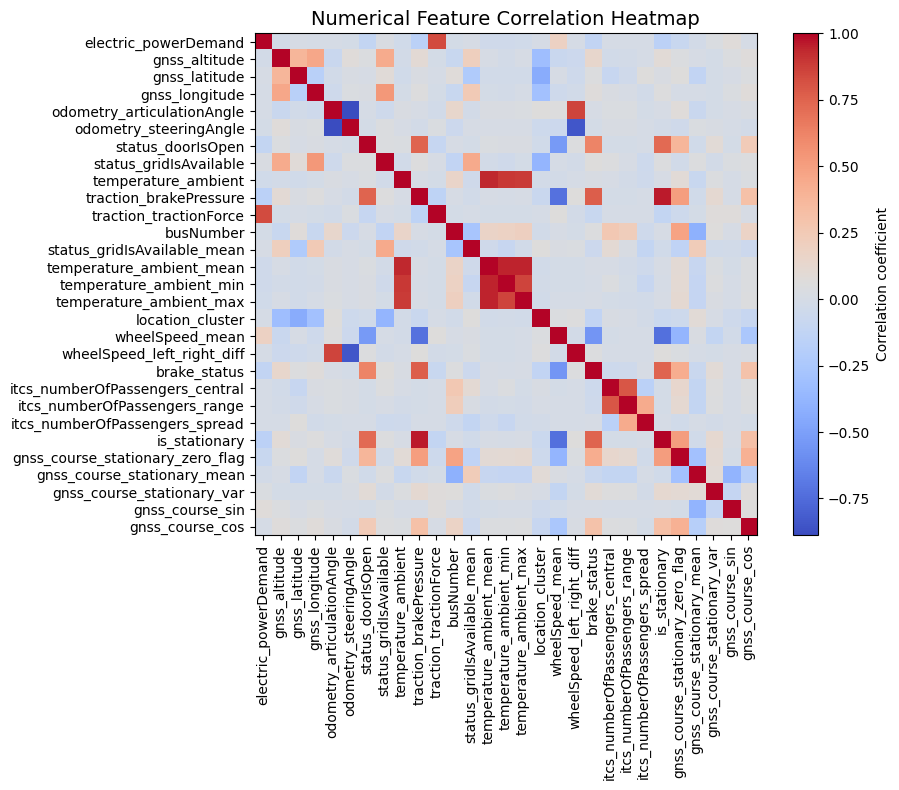

In [90]:
correlated = plotNumericCorrelations(ZTBus, corr_threshold=0.6)

In [91]:
print("Highly correlated feature pairs:")
for f1, f2, val in correlated:
    print(f"{f1} ↔ {f2} : corr = {val:.2f}")

Highly correlated feature pairs:
electric_powerDemand ↔ traction_tractionForce : corr = 0.83
odometry_articulationAngle ↔ odometry_steeringAngle : corr = -0.89
odometry_articulationAngle ↔ wheelSpeed_left_right_diff : corr = 0.85
odometry_steeringAngle ↔ wheelSpeed_left_right_diff : corr = -0.84
status_doorIsOpen ↔ traction_brakePressure : corr = 0.74
status_doorIsOpen ↔ brake_status : corr = 0.62
status_doorIsOpen ↔ is_stationary : corr = 0.72
temperature_ambient ↔ temperature_ambient_mean : corr = 0.94
temperature_ambient ↔ temperature_ambient_min : corr = 0.89
temperature_ambient ↔ temperature_ambient_max : corr = 0.89
traction_brakePressure ↔ wheelSpeed_mean : corr = -0.72
traction_brakePressure ↔ brake_status : corr = 0.76
traction_brakePressure ↔ is_stationary : corr = 0.96
temperature_ambient_mean ↔ temperature_ambient_min : corr = 0.95
temperature_ambient_mean ↔ temperature_ambient_max : corr = 0.94
temperature_ambient_min ↔ temperature_ambient_max : corr = 0.86
wheelSpeed_mean

In [92]:
gc.collect()

9659

-- Round off values based on some core information to make the data points ready for a classification model --

In [93]:
# Keep temperate within two decimal places

ZTBus["temperature_ambient"] = ZTBus["temperature_ambient"].round(2)

In [94]:
# Convert brake Pressure from Pascal (Pa) to kilo Pascal (kPa)

ZTBus["traction_brakePressure"] = (ZTBus["traction_brakePressure"]/1000).round(3)

In [95]:
# Convert brake Pressure from Newton (N) to kilo Newton (MN)

ZTBus["traction_tractionForce"] = (ZTBus["traction_tractionForce"]/1000).round(3)

In [96]:
# Convert brake Pressure from Watt (W) to Mega Watt (mW)

ZTBus["electric_powerDemand"] = (ZTBus["electric_powerDemand"]/1e6).round(3)

In [97]:
ZTBus.head()

,electric_powerDemand,gnss_altitude,gnss_latitude,gnss_longitude,odometry_articulationAngle,odometry_steeringAngle,status_doorIsOpen,status_gridIsAvailable,temperature_ambient,traction_brakePressure,...,brake_status,itcs_numberOfPassengers_central,itcs_numberOfPassengers_range,itcs_numberOfPassengers_spread,is_stationary,gnss_course_stationary_zero_flag,gnss_course_stationary_mean,gnss_course_stationary_var,gnss_course_sin,gnss_course_cos
19525,0.008,440.702911,0.826673,0.149307,0.008727,-0.0,0.0,1.0,293.149994,249.167,...,2,33.114578,70,2.113873,1,0,2.00174,0.0,0.908572,-0.417728
19526,0.008,440.702911,0.826673,0.149307,0.008727,-0.0,0.0,1.0,293.149994,249.167,...,2,33.114578,70,2.113873,1,0,2.00174,0.0,0.908572,-0.417728
19527,0.008,440.702911,0.826673,0.149307,0.008727,-0.0,0.0,1.0,293.149994,248.033,...,2,33.114578,70,2.113873,1,0,2.00174,0.0,0.908572,-0.417728
19528,0.008,440.702911,0.826673,0.149307,0.008727,-0.0,0.0,1.0,293.149994,249.167,...,2,33.114578,70,2.113873,1,0,2.00174,0.0,0.908572,-0.417728
19529,0.008,440.702911,0.826673,0.149307,0.008727,-0.0,0.0,1.0,293.149994,248.651,...,2,33.114578,70,2.113873,1,0,2.00174,0.0,0.908572,-0.417728


In [98]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 7160.33 MB
Reduced size: 5278.45 MB (26.3% reduction)


In [99]:
ZTBus_Summary

,column,dtype,min,max
0,electric_powerDemand,float32,-0.323,0.381
1,gnss_altitude,float32,330.94516,555.033508
2,gnss_latitude,float32,0.822585,0.853783
3,gnss_longitude,float32,-0.051144,0.159485
4,odometry_articulationAngle,float32,-0.94248,0.933753
5,odometry_steeringAngle,float32,-0.94248,0.94248
6,status_doorIsOpen,float32,0.0,1.0
7,status_gridIsAvailable,float32,0.0,1.0
8,temperature_ambient,float32,273.149994,311.149994
9,traction_brakePressure,float32,0.0,933.333008


In [100]:
gc.collect()

0

In [101]:
ZTBus.drop(columns = ["temperature_ambient_min", 
                      "temperature_ambient_mean", 
                      "temperature_ambient_max"], inplace = True)

In [102]:
ZTBus.shape

(48129193, 28)

In [103]:
ZTBus.drop(columns = ["status_gridIsAvailable_mean"], inplace = True)

In [104]:
# Remove the odometry correlated features

ZTBus.drop(columns = ["odometry_articulationAngle", "odometry_steeringAngle"], inplace = True)

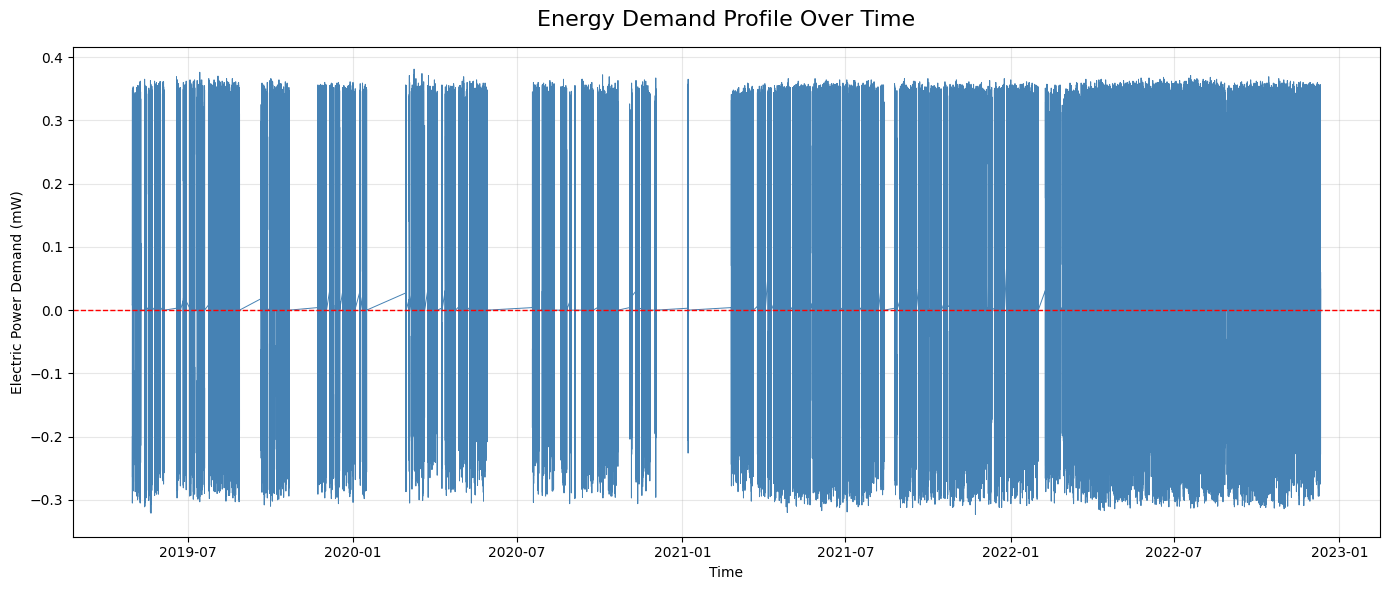

In [105]:
# Ensure datetime
ZTBus['timestamp'] = pd.to_datetime(ZTBus['timestamp'])

# ---------------- 1. Energy Demand Profile ----------------
plt.figure(figsize=(14,6))
plt.plot(ZTBus['timestamp'], ZTBus['electric_powerDemand'], lw=0.7, color="steelblue")
plt.axhline(0, color="red", linestyle="--", lw=1)
plt.title("Energy Demand Profile Over Time", fontsize=16, pad=15)
plt.xlabel("Time")
plt.ylabel("Electric Power Demand (mW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig("energyDemandProfile.jpg", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\Saransh\AppData\Local\Temp\ipykernel_6020\4104508607.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ZTBus, x="busRoute", y="itcs_numberOfPassengers_central", palette="Set2")


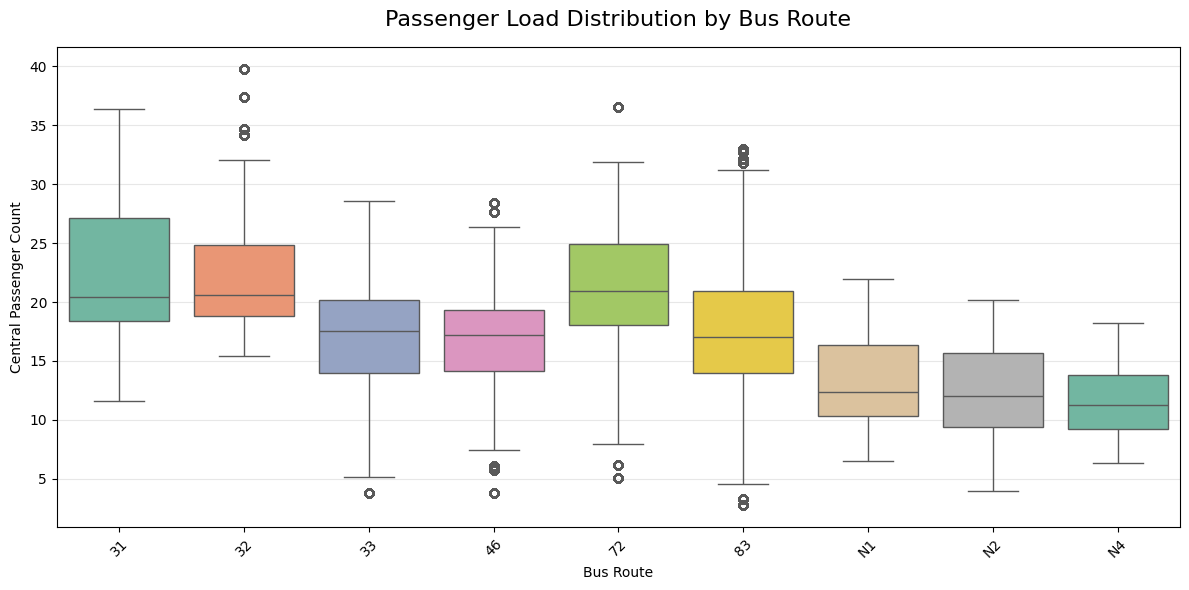

In [106]:
# ---------------- 2. Passenger Load by Route ----------------
plt.figure(figsize=(12,6))
sns.boxplot(data=ZTBus, x="busRoute", y="itcs_numberOfPassengers_central", palette="Set2")
plt.title("Passenger Load Distribution by Bus Route", fontsize=16, pad=15)
plt.xlabel("Bus Route")
plt.ylabel("Central Passenger Count")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.savefig("passengerLoadDistribution.jpg", dpi=300, bbox_inches="tight")
plt.show()

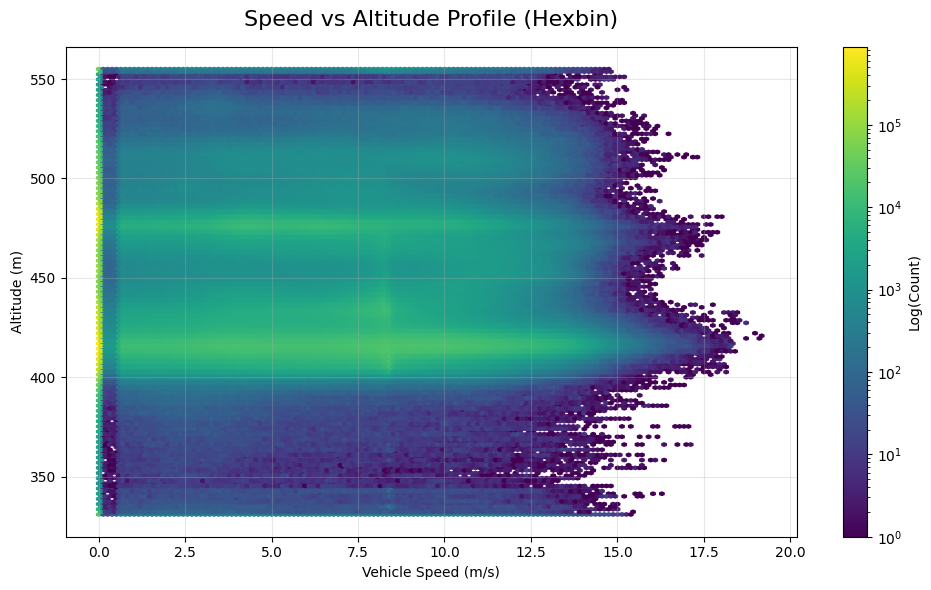

In [107]:
# ---------------- 3. Speed vs Altitude ----------------
plt.figure(figsize=(10,6))
hb = plt.hexbin(ZTBus['wheelSpeed_mean'], ZTBus['gnss_altitude'], 
                gridsize=150, cmap="viridis", mincnt=1, bins="log")
plt.colorbar(hb, label="Log(Count)")
plt.title("Speed vs Altitude Profile (Hexbin)", fontsize=16, pad=15)
plt.xlabel("Vehicle Speed (m/s)")
plt.ylabel("Altitude (m)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("speedvsaltitude.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [108]:
gc.collect()

9679

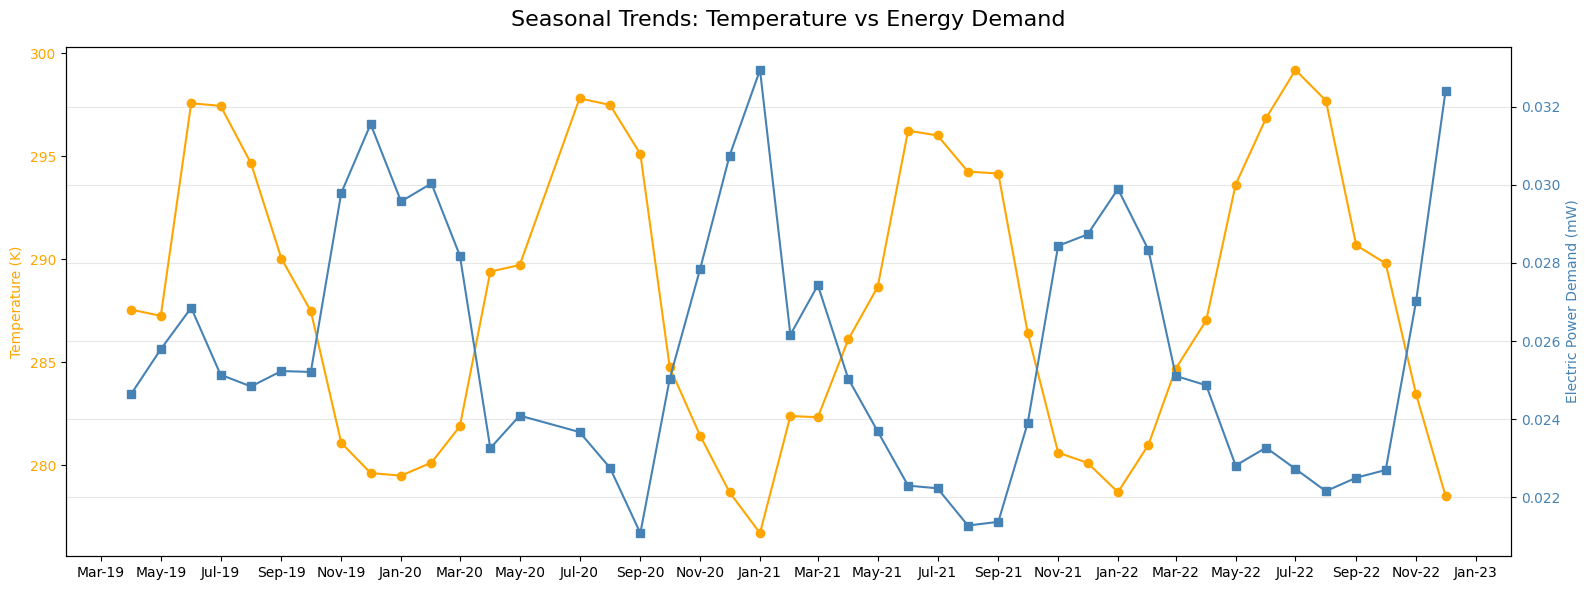

In [112]:
# ---------------- 4. Seasonal Trend ----------------
import matplotlib.dates as mdates


ZTBus['month_year'] = ZTBus['timestamp'].dt.to_period('M')
monthly = ZTBus.groupby('month_year').agg({
    'temperature_ambient':'mean',
    'electric_powerDemand':'mean'
}).reset_index()
monthly['month_year'] = monthly['month_year'].astype(str)

monthly['month_year_dt'] = monthly['month_year'].astype('period[M]').dt.to_timestamp()

fig, ax1 = plt.subplots(figsize=(16,6))

ax1.plot(monthly['month_year_dt'], monthly['temperature_ambient'], 
         color="orange", marker="o", label="Avg Temperature (K)")
ax1.set_ylabel("Temperature (K)", color="orange")
ax1.tick_params(axis='y', labelcolor="orange")

ax2 = ax1.twinx()
ax2.plot(monthly['month_year_dt'], monthly['electric_powerDemand'], 
         color="steelblue", marker="s", label="Avg Power Demand (mW)")
ax2.set_ylabel("Electric Power Demand (mW)", color="steelblue")
ax2.tick_params(axis='y', labelcolor="steelblue")

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))   # every 2nd month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

plt.title("Seasonal Trends: Temperature vs Energy Demand", fontsize=16, pad=15)
plt.grid(True, alpha=0.3)
fig.tight_layout()

plt.savefig("seasonalTrendTemperateVSEnergy.jpg", dpi=300, bbox_inches="tight")
plt.show()

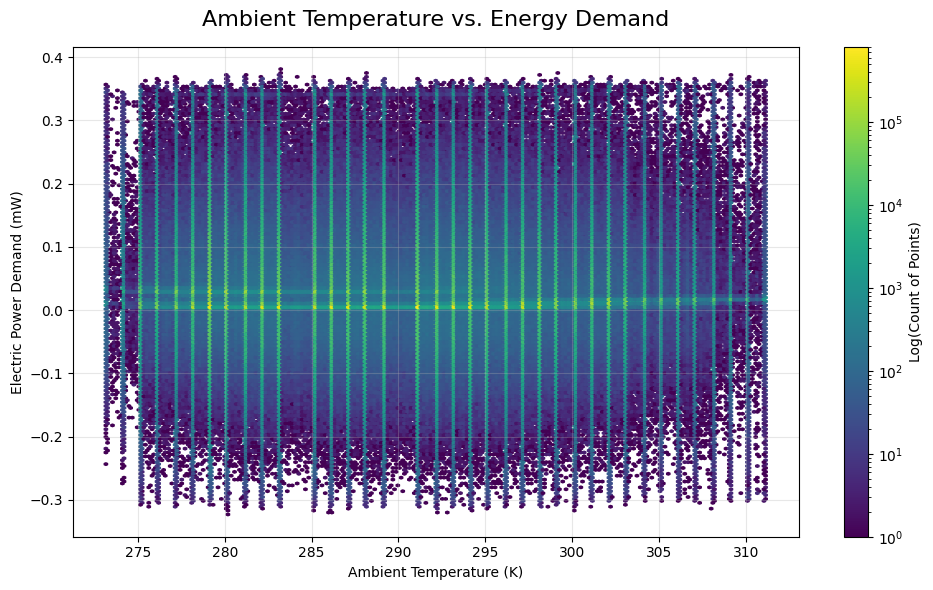

In [110]:
# ---------------- 5. Temperature vs Energy Demand ----------------
plt.figure(figsize=(10,6))
hb = plt.hexbin(ZTBus['temperature_ambient'], ZTBus['electric_powerDemand'],
                gridsize=200, cmap="viridis", mincnt=1, bins="log")

plt.colorbar(hb, label="Log(Count of Points)")
plt.title("Ambient Temperature vs. Energy Demand", fontsize=16, pad=15)
plt.xlabel("Ambient Temperature (K)")
plt.ylabel("Electric Power Demand (mW)")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("temperatureEnergyHVACAnalysis.jpg", dpi=300, bbox_inches="tight")
plt.show()

-- We start with the model building process to predict the bus number based on the feature engineered data points. --

----

----

-----

In [113]:
ZTBus, ZTBus_Summary = reduceMemoryUsage(ZTBus)

Initial size: 4544.06 MB
Reduced size: 4544.06 MB (0.0% reduction)


In [ ]:
ZTBus_Summary

In [115]:
gc.collect()

32801

In [120]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Convert pandas DataFrame to Dask DataFrame with 10 partitions
ddf = dd.from_pandas(ZTBus, npartitions=1)

# Write to single Parquet file with progress bar
with ProgressBar():
    ddf.to_parquet('finalData.parquet', compression='snappy', engine='pyarrow', write_index=False)

[########################################] | 100% Completed | 136.05 s


--- End of Analysis file ---

--------------------------

--------------------

---------------